
## Классификация изображений из датасета [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)


## Часть 1

Требования

1. Используйте фреймворк [Pytorch](https://pytorch.org/)

2. Не используйте предобученные модели.

3. Можете загрузить готовую модель или использовать собственную архитектуру.

4. Выберите способ оценки качества предсказаний модели. Обоснуйте его.

5. Проведите обучение. Продемонстрируйте умение использовать соответствующие инструменты.

6. Оцените полученный результат.

*Не используйте инструменты принцип работы которых вам непонятен.

### Данные

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
random.seed(21)
np.random.seed(21)
torch.cuda.manual_seed(21)
torch.backends.cudnn.deterministic = True

In [4]:
batch_size = 250

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(24),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform = val_transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000, 10000])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 28544128.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


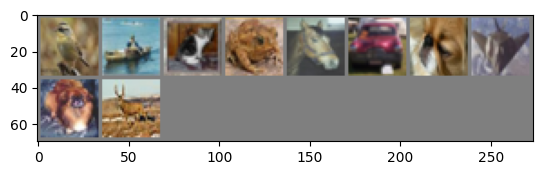

bird  ship  cat   frog  horse car   dog   plane dog   deer 


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:10]))
print(' '.join(f'{class_names[labels[j]]:5s}' for j in range(10)))

#### Сбаласированность классов

In [6]:
def check_class_balance(dataloader):
    classes = []
    for batch_idx, data in enumerate(dataloader, 0):
        x, y = data
        classes.extend(y.tolist())

    #Calculating the unique classes and the respective counts and plotting them
    unique, counts = np.unique(classes, return_counts=True)
    plt.bar(class_names, counts)
    plt.xlabel("Target Classes")
    plt.ylabel("Number of training instances")

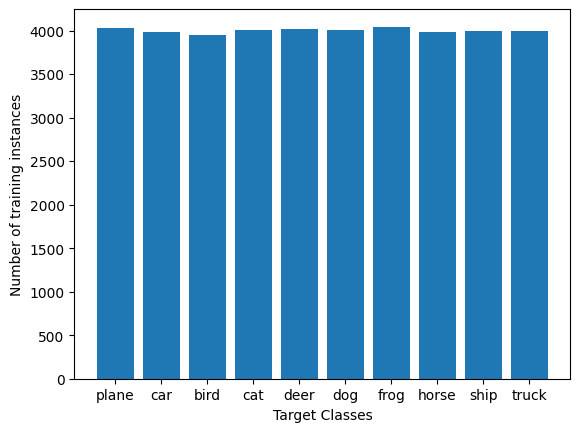

In [7]:
check_class_balance(train_dataloader)

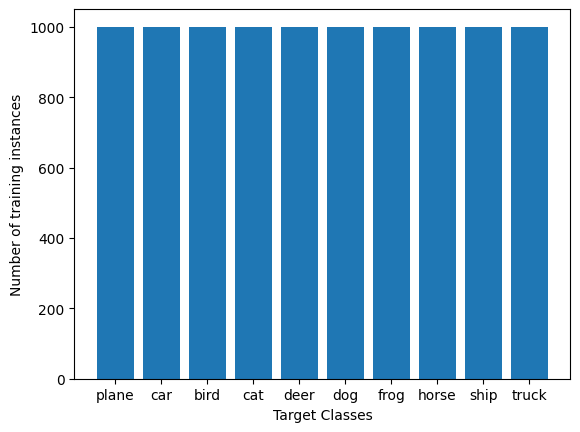

In [8]:
check_class_balance(test_dataloader)

Классы имеют незначительный дисбаланс

#### Метрики

Варианты метрик качества:  
Взвешанные Accuracy, Precision, Recall, F1  
Классы сбалансированы и нет дополнительных требований по тому в какую строну лучше не ошибаться, поэтому можно взять **Accuracy**

### Модель

In [9]:
# Папки для сохранения весов на эпохах
!mkdir ./check_points
!mkdir ./check_points/task_1

In [10]:
def save_model(model, model_path):
    torch.save(model.state_dict(), f"{model_path}{type(model).__name__}.pth")

def train_model(model, loss, optimizer, scheduler, num_epochs, checkpoints_folder):
    loss_history = {'train': [], 'val': []}
    accuracy_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()


            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            loss_history[phase].append(float(epoch_loss))
            accuracy_history[phase].append(float(epoch_acc.cpu()))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            save_model(model, f'./check_points/{checkpoints_folder}/epoch_{epoch}_')

    for phase in ['train', 'val']:
        plt.plot(accuracy_history[phase], label=phase)
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    min_acc = max(accuracy_history['val'])
    print(f"Best Val Accuracy:{min_acc} epoch {accuracy_history['val'].index (min_acc)}")

    for phase in ['train', 'val']:
        plt.plot(loss_history[phase], label=phase)
    plt.legend()
    plt.title('Loss')
    plt.show()
    min_loss = min(loss_history['val'])
    print(f"Best Val Loss:{min_loss} epoch {loss_history['val'].index (min_loss)}")


    return model

### Обучение

In [11]:
from torchvision.models import resnet34
resnet_34 = resnet34()

# Нам нужно на выходе 10 чисел
resnet_34.fc = torch.nn.Linear(resnet_34.fc.in_features, 10)

resnet_34 = resnet_34.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_34.parameters(), lr=0.001)

# Уменьшение LR в 0,1 раза каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 0/29:


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████| 160/160 [00:24<00:00,  6.57it/s]

train Loss: 1.5388 Acc: 0.4422



100%|██████████| 40/40 [00:03<00:00, 12.89it/s]

val Loss: 1.4299 Acc: 0.4983


Epoch 1/29:


100%|██████████| 160/160 [00:23<00:00,  6.79it/s]

train Loss: 1.1248 Acc: 0.5975



100%|██████████| 40/40 [00:03<00:00, 12.63it/s]

val Loss: 1.1105 Acc: 0.5990


Epoch 2/29:


100%|██████████| 160/160 [00:23<00:00,  6.73it/s]

train Loss: 0.9187 Acc: 0.6755



100%|██████████| 40/40 [00:03<00:00, 12.80it/s]

val Loss: 1.0328 Acc: 0.6399


Epoch 3/29:


100%|██████████| 160/160 [00:24<00:00,  6.64it/s]

train Loss: 0.7684 Acc: 0.7301



100%|██████████| 40/40 [00:03<00:00, 12.91it/s]

val Loss: 0.9962 Acc: 0.6487


Epoch 4/29:


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]

train Loss: 0.6514 Acc: 0.7707



100%|██████████| 40/40 [00:03<00:00, 12.53it/s]

val Loss: 1.0405 Acc: 0.6615


Epoch 5/29:


100%|██████████| 160/160 [00:24<00:00,  6.63it/s]

train Loss: 0.5519 Acc: 0.8069



100%|██████████| 40/40 [00:03<00:00, 12.68it/s]

val Loss: 0.9873 Acc: 0.6840


Epoch 6/29:


100%|██████████| 160/160 [00:24<00:00,  6.59it/s]

train Loss: 0.2815 Acc: 0.9076



100%|██████████| 40/40 [00:03<00:00, 13.02it/s]

val Loss: 0.8033 Acc: 0.7539


Epoch 7/29:


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]

train Loss: 0.1666 Acc: 0.9464



100%|██████████| 40/40 [00:03<00:00, 12.89it/s]

val Loss: 0.8932 Acc: 0.7508


Epoch 8/29:


100%|██████████| 160/160 [00:24<00:00,  6.59it/s]

train Loss: 0.1006 Acc: 0.9690



100%|██████████| 40/40 [00:03<00:00, 12.99it/s]

val Loss: 1.0603 Acc: 0.7485


Epoch 9/29:


100%|██████████| 160/160 [00:24<00:00,  6.62it/s]

train Loss: 0.0553 Acc: 0.9840



100%|██████████| 40/40 [00:03<00:00, 12.85it/s]

val Loss: 1.2813 Acc: 0.7404


Epoch 10/29:


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]

train Loss: 0.0318 Acc: 0.9905



100%|██████████| 40/40 [00:03<00:00, 12.69it/s]

val Loss: 1.4704 Acc: 0.7379


Epoch 11/29:


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]

train Loss: 0.0206 Acc: 0.9939



100%|██████████| 40/40 [00:03<00:00, 12.68it/s]

val Loss: 1.5854 Acc: 0.7419


Epoch 12/29:


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]

train Loss: 0.0210 Acc: 0.9935



100%|██████████| 40/40 [00:03<00:00, 13.00it/s]

val Loss: 1.7010 Acc: 0.7323


Epoch 13/29:


100%|██████████| 160/160 [00:24<00:00,  6.60it/s]

train Loss: 0.0121 Acc: 0.9967



100%|██████████| 40/40 [00:03<00:00, 12.49it/s]

val Loss: 1.6438 Acc: 0.7390


Epoch 14/29:


100%|██████████| 160/160 [00:24<00:00,  6.58it/s]

train Loss: 0.0051 Acc: 0.9992



100%|██████████| 40/40 [00:03<00:00, 12.50it/s]

val Loss: 1.6699 Acc: 0.7414


Epoch 15/29:


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]

train Loss: 0.0041 Acc: 0.9994



100%|██████████| 40/40 [00:03<00:00, 12.96it/s]

val Loss: 1.6974 Acc: 0.7407


Epoch 16/29:


100%|██████████| 160/160 [00:24<00:00,  6.57it/s]

train Loss: 0.0031 Acc: 0.9996



100%|██████████| 40/40 [00:03<00:00, 12.84it/s]

val Loss: 1.7067 Acc: 0.7421


Epoch 17/29:


100%|██████████| 160/160 [00:24<00:00,  6.60it/s]

train Loss: 0.0032 Acc: 0.9997



100%|██████████| 40/40 [00:03<00:00, 12.88it/s]

val Loss: 1.7207 Acc: 0.7413


Epoch 18/29:


100%|██████████| 160/160 [00:24<00:00,  6.60it/s]

train Loss: 0.0025 Acc: 0.9998



100%|██████████| 40/40 [00:03<00:00, 12.83it/s]

val Loss: 1.7382 Acc: 0.7412


Epoch 19/29:


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]

train Loss: 0.0021 Acc: 0.9999



100%|██████████| 40/40 [00:03<00:00, 12.93it/s]

val Loss: 1.7700 Acc: 0.7418


Epoch 20/29:


100%|██████████| 160/160 [00:24<00:00,  6.59it/s]

train Loss: 0.0021 Acc: 0.9998



100%|██████████| 40/40 [00:03<00:00, 12.69it/s]

val Loss: 1.7779 Acc: 0.7413


Epoch 21/29:


100%|██████████| 160/160 [00:24<00:00,  6.59it/s]

train Loss: 0.0018 Acc: 0.9999



100%|██████████| 40/40 [00:03<00:00, 12.83it/s]

val Loss: 1.7696 Acc: 0.7409


Epoch 22/29:


100%|██████████| 160/160 [00:24<00:00,  6.56it/s]

train Loss: 0.0019 Acc: 0.9999



100%|██████████| 40/40 [00:03<00:00, 12.40it/s]

val Loss: 1.7690 Acc: 0.7409


Epoch 23/29:


100%|██████████| 160/160 [00:24<00:00,  6.58it/s]

train Loss: 0.0019 Acc: 0.9999



100%|██████████| 40/40 [00:03<00:00, 12.66it/s]

val Loss: 1.7841 Acc: 0.7406


Epoch 24/29:


100%|██████████| 160/160 [00:24<00:00,  6.60it/s]

train Loss: 0.0016 Acc: 0.9999



100%|██████████| 40/40 [00:03<00:00, 12.54it/s]

val Loss: 1.7763 Acc: 0.7411


Epoch 25/29:


100%|██████████| 160/160 [00:24<00:00,  6.54it/s]

train Loss: 0.0017 Acc: 1.0000



100%|██████████| 40/40 [00:03<00:00, 13.02it/s]

val Loss: 1.7755 Acc: 0.7416


Epoch 26/29:


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]

train Loss: 0.0018 Acc: 0.9998



100%|██████████| 40/40 [00:03<00:00, 12.85it/s]

val Loss: 1.7835 Acc: 0.7409


Epoch 27/29:


100%|██████████| 160/160 [00:24<00:00,  6.59it/s]

train Loss: 0.0017 Acc: 0.9999



100%|██████████| 40/40 [00:03<00:00, 12.67it/s]

val Loss: 1.7902 Acc: 0.7417


Epoch 28/29:


100%|██████████| 160/160 [00:24<00:00,  6.61it/s]

train Loss: 0.0016 Acc: 0.9999



100%|██████████| 40/40 [00:03<00:00, 12.93it/s]

val Loss: 1.7917 Acc: 0.7407


Epoch 29/29:


100%|██████████| 160/160 [00:24<00:00,  6.64it/s]

train Loss: 0.0016 Acc: 0.9999



100%|██████████| 40/40 [00:03<00:00, 12.98it/s]

val Loss: 1.7936 Acc: 0.7415


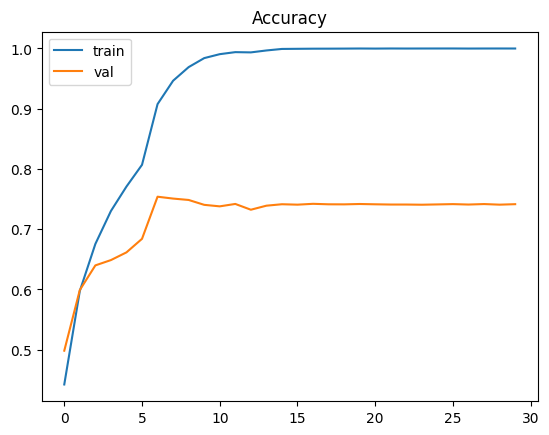

Best Val Accuracy:0.7539001107215881 epoch 6


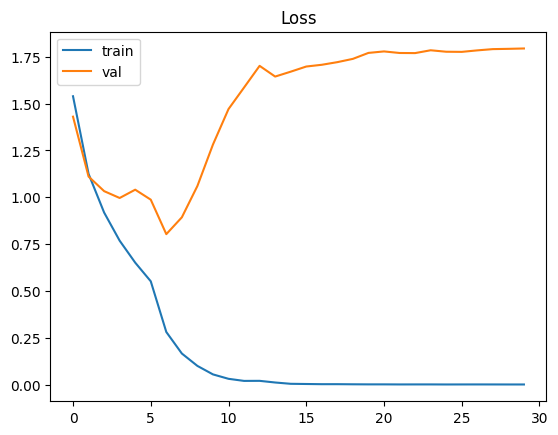

Best Val Loss:0.8033192157745361 epoch 6


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
train_model(resnet_34, loss, optimizer, scheduler, num_epochs=30, checkpoints_folder='task_1')

### Оценка результата

Лучшшие показатели были на 6 эпохе на них и проверим accuracy модели

In [13]:
def download_model(model_class, path):
    model = model_class.load_state_dict(torch.load(f"{path}"))
    return model

In [14]:
# Берем  модель из лучшей эпохи
resnet_34_best = resnet34()
resnet_34_best.fc = torch.nn.Linear(resnet_34_best.fc.in_features, 10)
resnet_34_best = resnet_34_best.to(device)

resnet_34_best.load_state_dict(torch.load('/kaggle/working/check_points/task_1/epoch_6_ResNet.pth'))

<All keys matched successfully>

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

def preds_heatmap(model, dataloader):
    y_pred = []
    y_true = []

    # iterate over test data
    for x, y in dataloader:

        #print('iter val', i)
        x = x.to(device)
        y = y.to(device)
        z = model(x)
        _, yhat = torch.max(z, 1)
        pred = yhat.data.cpu().numpy()
        y_pred.extend(pred) # Save Prediction

        labels = y.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
                         columns = [i for i in class_names])
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)
    plt.savefig('output.png')
    print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       plane       0.76      0.78      0.77      1000
         car       0.83      0.85      0.84      1000
        bird       0.66      0.65      0.66      1000
         cat       0.54      0.51      0.53      1000
        deer       0.69      0.70      0.70      1000
         dog       0.63      0.64      0.63      1000
        frog       0.78      0.80      0.79      1000
       horse       0.78      0.78      0.78      1000
        ship       0.86      0.85      0.85      1000
       truck       0.80      0.79      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



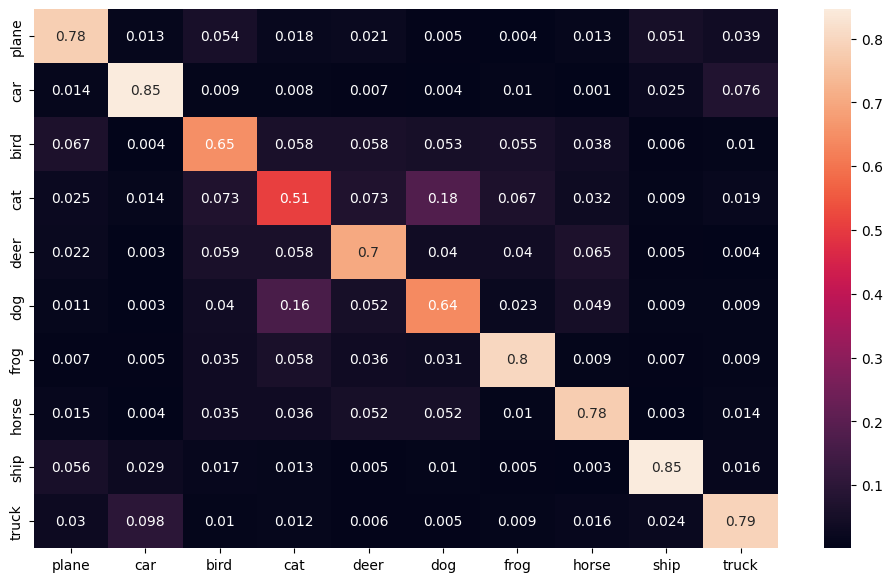

In [19]:
preds_heatmap(resnet_34_best, test_dataloader)

Выводы по модели:
- лучше всего классифицируются корабль и автомобиль - 85% верно
- хуже всего кошка - 51% верно, в 16% путается с собакой

## Часть 2


1. Решите ту же задачу, но без ограничения на использование предобученных моделей.

2. Проведите сравнительный анализ результатов полученных в первой и второй части.


In [14]:
torch.cuda.empty_cache()

In [15]:
batch_size = 250

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(24),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_val_dataset = datasets.CIFAR10(root='./data', train=True, download=False)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform = val_transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [40000, 10000])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [16]:
from torchvision.models import resnet34
resnet_34_pt = resnet34(pretrained=True)

# Disable grad for all conv layers
for param in resnet_34_pt.parameters():
    param.requires_grad = False

resnet_34_pt.fc = torch.nn.Linear(resnet_34_pt.fc.in_features, 10)

resnet_34_pt = resnet_34_pt.to(device)

loss_pt = torch.nn.CrossEntropyLoss()
optimizer_pt = torch.optim.Adam(resnet_34_pt.parameters(), lr=0.001)

scheduler_pt = torch.optim.lr_scheduler.StepLR(optimizer_pt, step_size=5, gamma=0.1)

In [17]:
print("Слои подлежащие обучению:")
for name, param in resnet_34_pt.named_parameters():
    if param.requires_grad:
        print(name)

Слои подлежащие обучению:
fc.weight
fc.bias


In [9]:
!mkdir ./check_points/task_2

In [18]:
train_model(resnet_34_pt, loss_pt, optimizer_pt, scheduler_pt, num_epochs=15, checkpoints_folder='task_2')

Epoch 0/14:


100%|██████████| 160/160 [01:55<00:00,  1.38it/s]

train Loss: 1.0601 Acc: 0.6810



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val Loss: 0.7112 Acc: 0.7780
Epoch 1/14:



100%|██████████| 160/160 [01:55<00:00,  1.38it/s]

train Loss: 0.6502 Acc: 0.7907



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val Loss: 0.6117 Acc: 0.7953
Epoch 2/14:



100%|██████████| 160/160 [01:56<00:00,  1.38it/s]

train Loss: 0.5890 Acc: 0.8037



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val Loss: 0.5789 Acc: 0.8058
Epoch 3/14:



100%|██████████| 160/160 [01:55<00:00,  1.38it/s]

train Loss: 0.5598 Acc: 0.8089



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val Loss: 0.5644 Acc: 0.8071
Epoch 4/14:



100%|██████████| 160/160 [01:55<00:00,  1.38it/s]

train Loss: 0.5364 Acc: 0.8183



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val Loss: 0.5545 Acc: 0.8091
Epoch 5/14:



100%|██████████| 160/160 [01:56<00:00,  1.38it/s]

train Loss: 0.5331 Acc: 0.8201



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]

val Loss: 0.5521 Acc: 0.8101
Epoch 6/14:



  6%|▋         | 10/160 [00:07<01:59,  1.26it/s]


KeyboardInterrupt: 

Fine-tuning

In [19]:
# Разморозим все слои чтобы дообучить 
for param in resnet_34_pt.parameters():
    param.requires_grad = True

In [20]:
train_model(resnet_34_pt, loss_pt, optimizer_pt, scheduler_pt, num_epochs=10, checkpoints_folder='task_2')

Epoch 0/9:


100%|██████████| 160/160 [03:52<00:00,  1.45s/it]

train Loss: 0.2219 Acc: 0.9246



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val Loss: 0.1543 Acc: 0.9449
Epoch 1/9:



100%|██████████| 160/160 [03:53<00:00,  1.46s/it]

train Loss: 0.0390 Acc: 0.9884



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val Loss: 0.1594 Acc: 0.9491
Epoch 2/9:



100%|██████████| 160/160 [03:53<00:00,  1.46s/it]

train Loss: 0.0089 Acc: 0.9984



100%|██████████| 40/40 [00:28<00:00,  1.43it/s]

val Loss: 0.1295 Acc: 0.9566
Epoch 3/9:



100%|██████████| 160/160 [03:54<00:00,  1.47s/it]

train Loss: 0.0040 Acc: 0.9999



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val Loss: 0.1284 Acc: 0.9587
Epoch 4/9:



100%|██████████| 160/160 [03:54<00:00,  1.46s/it]

train Loss: 0.0027 Acc: 1.0000



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val Loss: 0.1279 Acc: 0.9584
Epoch 5/9:



100%|██████████| 160/160 [03:55<00:00,  1.47s/it]

train Loss: 0.0020 Acc: 1.0000



100%|██████████| 40/40 [00:28<00:00,  1.42it/s]

val Loss: 0.1280 Acc: 0.9589
Epoch 6/9:



  6%|▌         | 9/160 [00:13<03:47,  1.50s/it]


KeyboardInterrupt: 

In [24]:
torch.cuda.empty_cache()

In [36]:
device = torch.device('cpu')

In [37]:
device

device(type='cpu')

In [38]:
# Берем  модель из лучшей эпохи
resnet_34_pt_best = resnet34()
resnet_34_pt_best.fc = torch.nn.Linear(resnet_34_pt_best.fc.in_features, 10)
resnet_34_pt_best = resnet_34_pt_best.to(device)

resnet_34_pt_best.load_state_dict(torch.load('/kaggle/working/check_points/task_2/epoch_5_ResNet.pth'))

<All keys matched successfully>

              precision    recall  f1-score   support

       plane       0.95      0.97      0.96      1000
         car       0.97      0.98      0.98      1000
        bird       0.97      0.94      0.96      1000
         cat       0.89      0.91      0.90      1000
        deer       0.94      0.96      0.95      1000
         dog       0.94      0.92      0.93      1000
        frog       0.97      0.97      0.97      1000
       horse       0.96      0.96      0.96      1000
        ship       0.97      0.98      0.97      1000
       truck       0.97      0.96      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



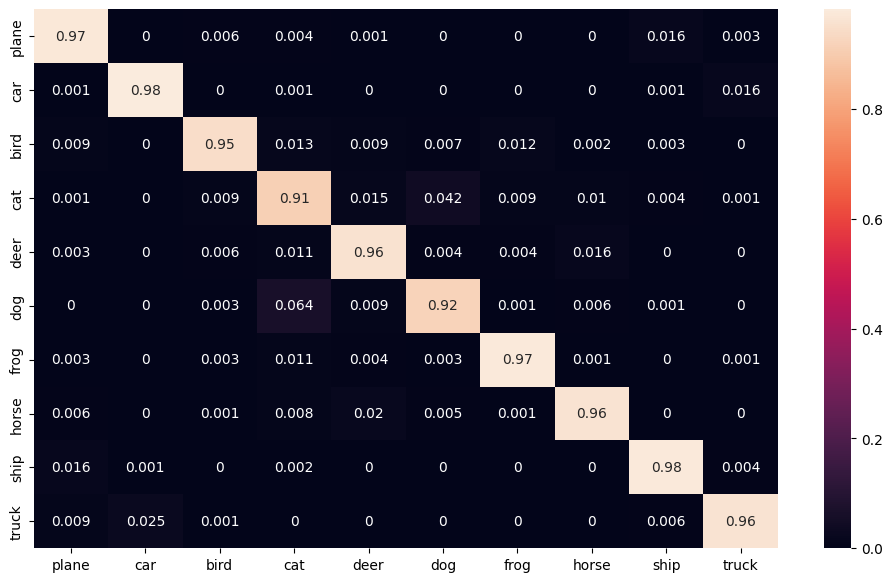

In [39]:
preds_heatmap(resnet_34_pt_best, test_dataloader)

## Вывод

Модель 1 ResNet34(не предобученная):
- Accuracy 73%
- лучше всего классифицируются корабль и автомобиль - 85% верно
- хуже всего кошка - 51% верно, в 16% путается с собакой
- довольно быстро училась так как размеры изображений подавались 32*32
- потребовалось больше эпох чем для второй модели

Модель 2 ResNet34(предобученная):
- Accuracy 95%
- лучше всего также классифицируются корабль и автомобиль - 98% верно
- хуже всего также кошка - 91% верно
- довольно долго училась так как размеры изображений подавались 32*32
- потребовалось меньше эпох для достижения результата